In [1]:
import requests
import pandas as pd
import time
from cryptocmd import CmcScraper
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
# list of cryptocurrencies to scrape
crypto_list = ['BTC', 'ETH', 'USDT', 'USDC', 'BNB', 'ADA', 'XRP', 'SOL', 'DOGE', 'DOT', 'DAI', 'TRX', 'SHIB', 'AVAX', 'LTC', 'FTT', 'XLM', 'LINK', 'MATIC', 'BCH', 'UNI', 'ALGO', 'VET', 'HBAR', 'SAND', 'MANA', 'AXS', 'XTZ', 'EOS', 'AAVE', 'HT', 'GRT', 'FTM', 'PAXG', 'ZIL', 'BAT', 'CHZ', 'ENJ', 'LRC', 'GALA', 'COMP']

# empty list to store scraped data
data = []

# loop over cryptocurrencies
for crypto in crypto_list:
    # scrape data for each cryptocurrency
    scraper = CmcScraper(crypto, "15-09-2022", "01-03-2023")
    df = scraper.get_dataframe()
    
    # add cryptocurrency name to dataframe
    df['Name'] = crypto
    
    # append dataframe to list of data
    data.append(df)

# combine dataframes for each cryptocurrency
df_combined = pd.concat(data)

df_combined = df_combined.loc[:, ['Date', 'Close', 'Market Cap', 'Name']]

In [3]:
# Read the ESG scores dataframe from the CSV file
esg_scores = pd.read_csv('CRYPTOESG.csv')

# Merge the two dataframes on the 'Name' column
merged_data = pd.merge(df_combined, esg_scores, on='Name')

In [14]:
print(merged_data)

           Date         Close    Market Cap  Name ESG   E  S  G
0    2023-03-01  23646.549899  4.565082e+11   BTC    C  E  A  B
1    2023-02-28  23147.353390  4.468468e+11   BTC    C  E  A  B
2    2023-02-27  23522.871915  4.540752e+11   BTC    C  E  A  B
3    2023-02-26  23561.212911  4.547952e+11   BTC    C  E  A  B
4    2023-02-25  23175.375636  4.473240e+11   BTC    C  E  A  B
...         ...           ...           ...   ...  ... .. .. ..
6883 2022-09-19     52.125630  3.788049e+08  COMP    B  A  C  B
6884 2022-09-18     49.423509  3.591682e+08  COMP    B  A  C  B
6885 2022-09-17     54.493153  3.960100e+08  COMP    B  A  C  B
6886 2022-09-16     54.003687  3.924530e+08  COMP    B  A  C  B
6887 2022-09-15     56.501139  4.106024e+08  COMP    B  A  C  B

[6888 rows x 8 columns]


# Creation of ESG portfolios

## Equally weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                     -0.0164097            0.00855426       -0.183861        -0.319249             0.523914  -0.0109748
 1  B                      0.102158             0.0194959         0.474264         0.758248             0.74391    0.00445501
 2  C                      0.198927             0.026366          0.654098         1.02197              0.857034  -0.0269301
 3  D                      0.734112             0.0388477         1.34701          2.42502              1.35313   -0.115055


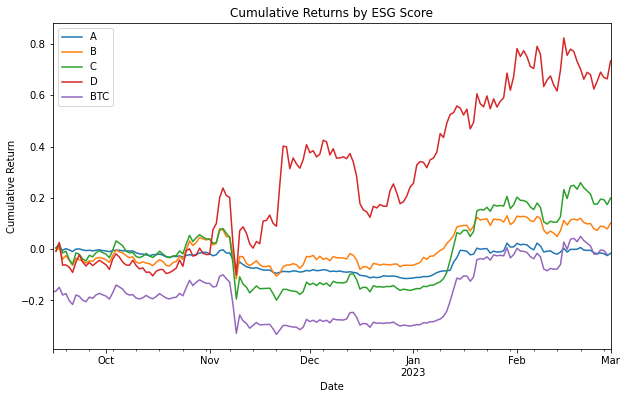

In [37]:
esg_scores = ['A', 'B', 'C', 'D']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')['Close']

for score in esg_scores:
    esg_df = merged_data[merged_data['ESG ']==score]
    portfolio_df = esg_df.groupby('Date').sum()['Close']

    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df / btc_df.shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std())* np.sqrt(252) 
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by ESG Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()


# Create table of portfolio metrics for all scores
results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)

# Format table with tabulate
table_str = tabulate(results_table, headers='keys', tablefmt='simple')

# Print formatted table
print(table_str)


## Capitalization weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio          Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  ------------
 0  A                   -0.000423204           0.000210403       -0.191238        -0.315933             0.645785   0.000338694
 1  B                    0.160613              0.0369886          0.382782         0.584805             0.611978  -0.0055055
 2  C                    0.223097              0.0255366          0.749635         1.18827              0.917207  -0.0367146
 3  D                    1.01174               0.0571876          1.16187          2.10857              1.21385   -0.152177


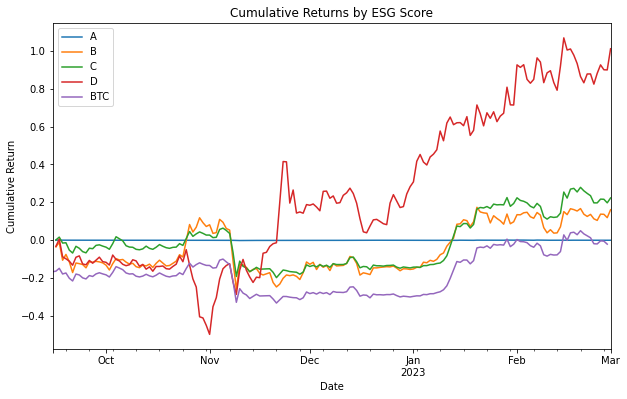

In [38]:
esg_scores = ['A', 'B', 'C', 'D']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')
btc_market_cap = btc_df.iloc[0]['Market Cap']
btc_weights = btc_df['Market Cap'] / btc_market_cap

for score in esg_scores:
    esg_df = merged_data[merged_data['ESG ']==score]
    portfolio_df = esg_df.groupby('Date').apply(lambda x: np.sum(x['Close']*x['Market Cap']) / np.sum(x['Market Cap']))
    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df['Close'] / btc_df['Close'].shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std())* np.sqrt(252) 
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by ESG Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)
table_str = tabulate(results_table, headers='keys', tablefmt='simple')
print(table_str)


# Creation of E portfolios

## Equally weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                      0.0979241             0.0197343        0.449995         0.716605             0.729708   0.00514403
 1  B                      0.145071              0.0540048        0.238442         0.450306             0.469078  -0.241386
 2  E                      0.201412              0.026338         0.662264         1.03533              0.86235   -0.027346


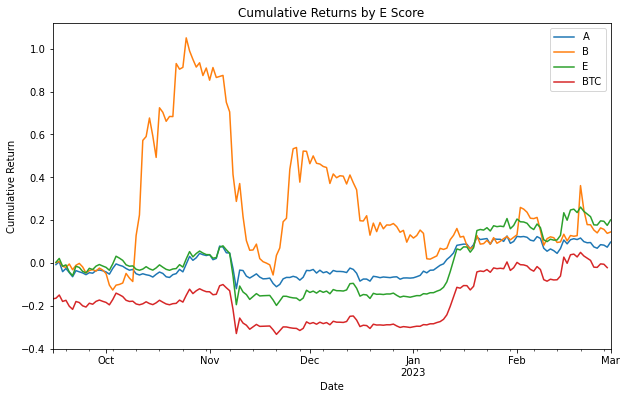

In [39]:
e_scores = ['A', 'B', 'E']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')['Close']

for score in e_scores:
    esg_df = merged_data[merged_data['E']==score]
    portfolio_df = esg_df.groupby('Date').sum()['Close']

    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df / btc_df.shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std())* np.sqrt(252) 
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by E Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()


# Create table of portfolio metrics for all scores
results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)

# Format table with tabulate
table_str = tabulate(results_table, headers='keys', tablefmt='simple')

# Print formatted table
print(table_str)

## Capitalization weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio        Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  ----------
 0  A                       0.214021             0.0466868        0.394869         0.603132             0.585248   0.0042281
 1  B                       0.145071             0.0540048        0.238442         0.450306             0.469078  -0.241386
 2  E                       0.191438             0.0260042        0.640289         1.00761              0.848089  -0.0245631


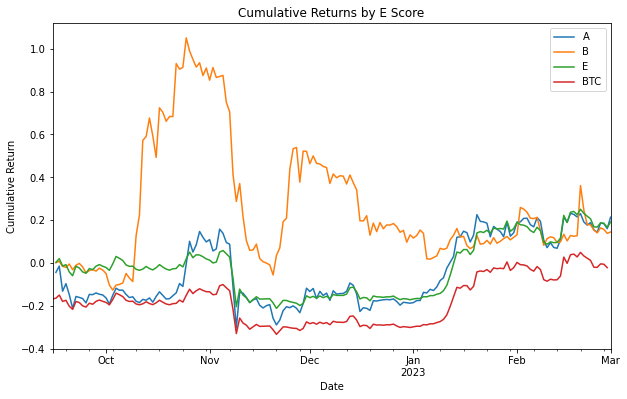

In [40]:
e_scores = ['A', 'B', 'E']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')
btc_market_cap = btc_df.iloc[0]['Market Cap']
btc_weights = btc_df['Market Cap'] / btc_market_cap

for score in e_scores:
    esg_df = merged_data[merged_data['E']==score]
    portfolio_df = esg_df.groupby('Date').apply(lambda x: np.sum(x['Close']*x['Market Cap']) / np.sum(x['Market Cap']))
    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df['Close'] / btc_df['Close'].shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std())* np.sqrt(252) 
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by E Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)
table_str = tabulate(results_table, headers='keys', tablefmt='simple')
print(table_str)

# Creation of S portfolios

## Equally weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                       0.199117            0.0263103         0.656054         1.02391              0.860179  -0.0236213
 1  B                       0.121679            0.00902456        1.20949          2.37249              0.956821  -0.00673052
 2  C                      -0.051337            0.0456658        -0.109703        -0.172685             0.130649   0.0714401
 3  D                       0.10872             0.0369763         0.265319         0.39767              0.517329  -0.0137335
 4  E                      -0.264525            0.0602896        -0.484414        -0.696766            -0.233548   0.142824


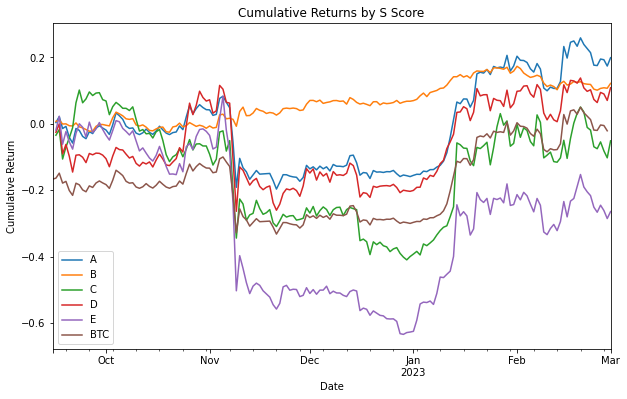

In [41]:
s_scores = ['A', 'B', 'C', 'D', 'E']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')['Close']

for score in s_scores:
    esg_df = merged_data[merged_data['S']==score]
    portfolio_df = esg_df.groupby('Date').sum()['Close']

    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df / btc_df.shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std())* np.sqrt(252) 
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by S Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()


# Create table of portfolio metrics for all scores
results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)

# Format table with tabulate
table_str = tabulate(results_table, headers='keys', tablefmt='simple')

# Print formatted table
print(table_str)

## Capitalization weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                      0.272591              0.032197        0.71168           1.11503              0.885783  -0.0499736
 1  B                      0.245241              0.0185466       1.12413           1.70489              1.11386   -0.037998
 2  C                     -0.0384766             0.0399781      -0.0932932        -0.142661             0.177072   0.0731152
 3  D                      0.140826              0.0370788       0.337768          0.517999             0.577544   0.00578711
 4  E                     -0.449363              0.0909158      -0.623858         -0.911775            -0.464341   0.260187


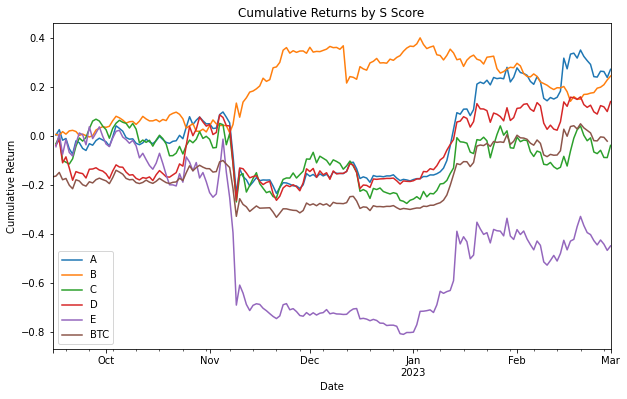

In [42]:
s_scores = ['A', 'B', 'C', 'D', 'E']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')
btc_market_cap = btc_df.iloc[0]['Market Cap']
btc_weights = btc_df['Market Cap'] / btc_market_cap

for score in s_scores:
    esg_df = merged_data[merged_data['S']==score]
    portfolio_df = esg_df.groupby('Date').apply(lambda x: np.sum(x['Close']*x['Market Cap']) / np.sum(x['Market Cap']))
    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df['Close'] / btc_df['Close'].shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std())* np.sqrt(252) 
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by S Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)
table_str = tabulate(results_table, headers='keys', tablefmt='simple')
print(table_str)

# Creation of G portfolios
## Equally weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                    0.000140694           0.000172734       0.0774195        0.098106              0.649455   0.00121133
 1  B                    0.19306               0.0243482         0.68915          1.08768               0.879134  -0.0258982
 2  C                    0.124259              0.0368213         0.302365         0.455708              0.547591   0.001839
 3  D                   -0.00849897            0.0347881        -0.0233223       -0.0338147             0.369777   0.118266
 4  E                    0.168918              0.0376291         0.394278         0.661573              0.669659   0.0454611


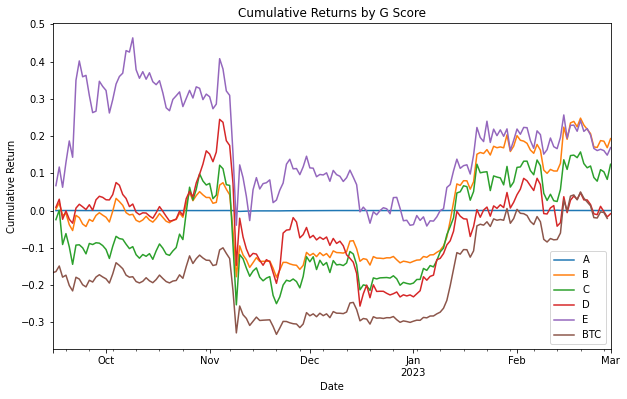

In [43]:
g_scores = ['A', 'B', 'C', 'D', 'E']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')['Close']

for score in g_scores:
    esg_df = merged_data[merged_data['G']==score]
    portfolio_df = esg_df.groupby('Date').sum()['Close']

    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df / btc_df.shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std())* np.sqrt(252) 
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by G Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()


# Create table of portfolio metrics for all scores
results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)

# Format table with tabulate
table_str = tabulate(results_table, headers='keys', tablefmt='simple')

# Print formatted table
print(table_str)

# Capitalization weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                    0.000140694           0.000172734       0.0774195         0.098106             0.649455   0.00121133
 1  B                    0.25759               0.0286582         0.760227          1.19049              0.931976  -0.0309264
 2  C                    0.133953              0.0366023         0.326472          0.496612             0.57341    0.00100716
 3  D                    0.160097              0.0323969         0.43573           0.677019             0.857725   0.257727
 4  E                    0.178071              0.0458376         0.339848          0.600836             0.599947   0.0593055


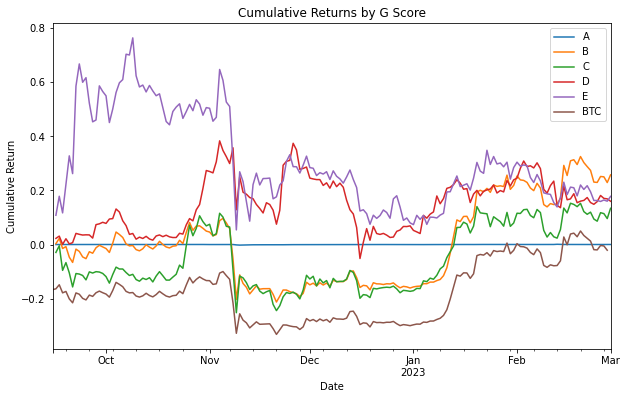

In [44]:
g_scores = ['A', 'B', 'C', 'D', 'E']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), lambda x: np.sqrt(252) * (np.mean(x) / np.std(x)), None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')
btc_market_cap = btc_df.iloc[0]['Market Cap']
btc_weights = btc_df['Market Cap'] / btc_market_cap

for score in g_scores:
    esg_df = merged_data[merged_data['G']==score]
    portfolio_df = esg_df.groupby('Date').apply(lambda x: np.sum(x['Close']*x['Market Cap']) / np.sum(x['Market Cap']))
    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df['Close'] / btc_df['Close'].shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std())* np.sqrt(252) 
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by G Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)
table_str = tabulate(results_table, headers='keys', tablefmt='simple')
print(table_str)